## Setting

### Optional

In [1]:
!pip install xgboost lightgbm catboost -U

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root = "/content/drive/MyDrive/3-2 기계학습/team project/"
import sys
sys.path.append(root)

### Required

In [4]:
from open.train_tuning import Model
from open.evaluation import show_confusion_matrix, show_roc_curve, show_pr_curve, show_prediction_score

is_binary = True

In [5]:
model_type = "rf"
param_grid = {
    'max_depth': [None, 4, 6],
    'max_samples': [None, 1.0],
    'n_estimators': [200, 300, 400]
}
selected_features = ['mean_iat', 'std_iat', 'median_iat', 'q25_iat', 'q75_iat', 'ratio_out',
       'switch_count', 'duration', 'n_packets', 'burst_count', 'burst_mean',
       'burst_std', 'burst_max', 'burst_ratio_in', 'num_in', 'num_out',
       'frac_in', 'in_first30', 'out_first30', 'mean_iat_first30',
       'std_iat_first30', 'median_iat_first30', 'q25_iat_first30',
       'q75_iat_first30', 'ratio_out_first30', 'switch_count_first30',
       'duration_first30', 'burst_count_first30', 'burst_mean_first30',
       'burst_std_first30', 'burst_max_first30', 'burst_ratio_in_first30',
       'frac_in_first30'] # fixed

## Loading Data

In [6]:
import pickle
import pandas as pd
import numpy as np

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/open_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y_binary"]
    y_train = np.where(y_train == -1, 0, y_train)

with open(f"{root}data/preprocess_data_33/open_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y_binary"]
    y_val = np.where(y_val == -1, 0, y_val)

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 20300
Validation data size:	 4350


In [7]:
# feature selection
def feature_selection(X, selected_features):
  return X[selected_features]

X_train = feature_selection(X_train, selected_features)
X_val = feature_selection(X_val, selected_features)

## Model

### Base Model Training

In [8]:
model = Model(is_binary=is_binary)
# change the model type and parameters accordingly
model.create_model(model_type, n_estimators = 2)
print(model.hparams)
model.fit(X_train, y_train)

{'n_estimators': 2, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_samples': 1}


In [9]:
y_test_pred = model.predict(X_val)
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
model.score(X_val, y_val)

0.3448275862068966

In [11]:
_ = model.k_fold_cv(X_train, y_train, k = 5)

5-fold Cross Validation Scores:	[0.34482759 0.34482759 0.34482759 0.34482759 0.65517241]
5-fold Cross Validation Average Score:	0.4068965517241379


### Feature Evaluation

In [12]:
model.get_feature_importances()

{'mean_iat': 0.0,
 'std_iat': 0.0,
 'median_iat': 0.0,
 'q25_iat': 0.0,
 'q75_iat': 0.0,
 'ratio_out': 0.0,
 'switch_count': 0.0,
 'duration': 0.0,
 'n_packets': 0.0,
 'burst_count': 0.0,
 'burst_mean': 0.0,
 'burst_std': 0.0,
 'burst_max': 0.0,
 'burst_ratio_in': 0.0,
 'num_in': 0.0,
 'num_out': 0.0,
 'frac_in': 0.0,
 'in_first30': 0.0,
 'out_first30': 0.0,
 'mean_iat_first30': 0.0,
 'std_iat_first30': 0.0,
 'median_iat_first30': 0.0,
 'q25_iat_first30': 0.0,
 'q75_iat_first30': 0.0,
 'ratio_out_first30': 0.0,
 'switch_count_first30': 0.0,
 'duration_first30': 0.0,
 'burst_count_first30': 0.0,
 'burst_mean_first30': 0.0,
 'burst_std_first30': 0.0,
 'burst_max_first30': 0.0,
 'burst_ratio_in_first30': 0.0,
 'frac_in_first30': 0.0}

### Hyperparameter Tuning

In [13]:
# define parameter search space
bst = model.grid_search(X_train, y_train, param_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=None, max_samples=None, n_estimators=200;, score=0.916 total time=  10.8s
[CV 2/5] END max_depth=None, max_samples=None, n_estimators=200;, score=0.920 total time=  10.5s
[CV 3/5] END max_depth=None, max_samples=None, n_estimators=200;, score=0.917 total time=  10.6s
[CV 4/5] END max_depth=None, max_samples=None, n_estimators=200;, score=0.920 total time=  10.5s
[CV 5/5] END max_depth=None, max_samples=None, n_estimators=200;, score=0.922 total time=  10.5s
[CV 1/5] END max_depth=None, max_samples=None, n_estimators=300;, score=0.915 total time=  15.7s
[CV 2/5] END max_depth=None, max_samples=None, n_estimators=300;, score=0.922 total time=  15.6s
[CV 3/5] END max_depth=None, max_samples=None, n_estimators=300;, score=0.915 total time=  16.8s
[CV 4/5] END max_depth=None, max_samples=None, n_estimators=300;, score=0.919 total time=  15.7s
[CV 5/5] END max_depth=None, max_samples=None, n_estimators=300;, 

### Evaluation

In [14]:
y = y_val
y_pred = bst.predict(X_val)
y_prob = bst.predict_proba(X_val)[:, 1]

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.91      0.86      0.88      1500
   monitored       0.93      0.95      0.94      2850

    accuracy                           0.92      4350
   macro avg       0.92      0.91      0.91      4350
weighted avg       0.92      0.92      0.92      4350



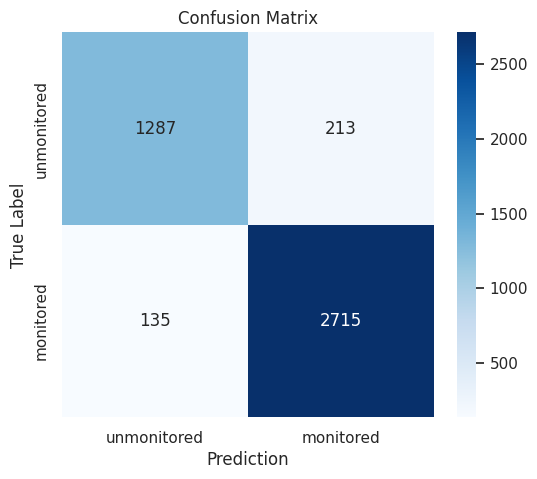

In [15]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.9761


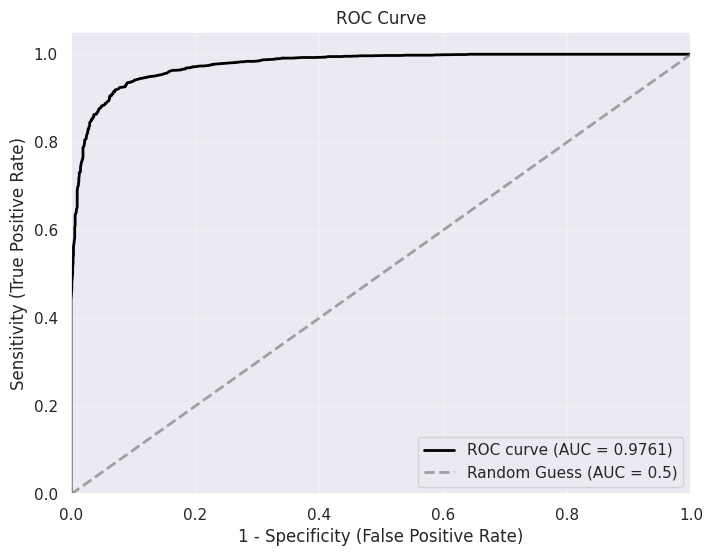

In [16]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9871


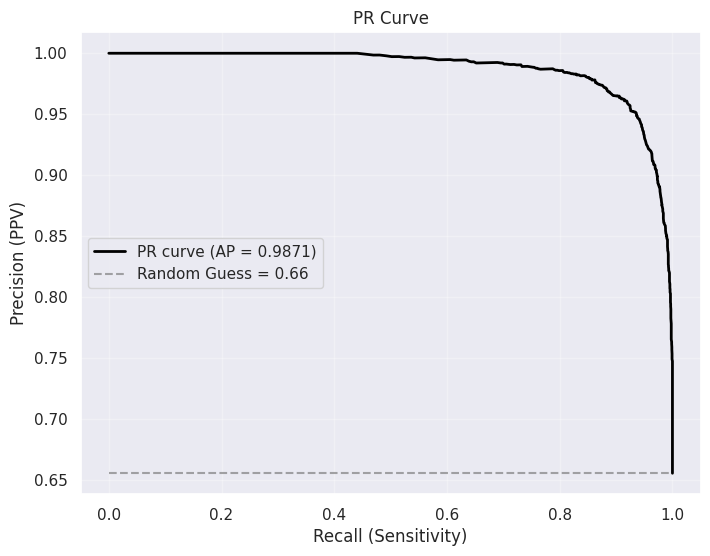

In [17]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


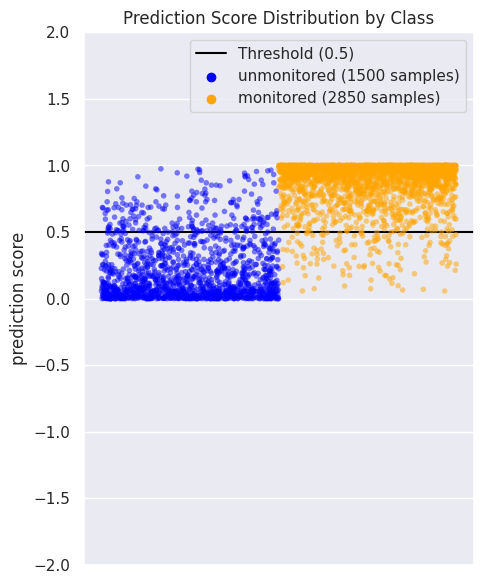

In [18]:
show_prediction_score(y, y_prob, model_type)

### Save Model

In [19]:
model.save_model(model=bst.best_estimator_, file_name=f"{bst.best_params_}")